In [ ]:
import os
import sys
import ffmpeg
import itertools
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from pytorch_msssim import ssim
import lpips
from tqdm import tqdm
from PIL import Image

from models import *
from utils import *
from helper import *

thirdparty_repo_path = os.path.abspath("/h/lkcai/code/video-perception/DCVC_HEM")
if thirdparty_repo_path not in sys.path:
    sys.path.insert(0, thirdparty_repo_path)

from DCVC_HEM.src.models.video_model import DMC
from DCVC_HEM.src.models.image_model import IntraNoAR
from DCVC_HEM.src.utils.stream_helper import get_state_dict

from video_quality_metrics.calculate_fvd import calculate_fvd


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
!nvidia-smi

/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mon Jan 27 15:29:24 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:86:00.0 Off |                    0 |
| N/A   40C    P0    28W /  70W |   6909MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
    return model

In [3]:
def PSNR(input1, input2):
    mse = torch.mean((input1 - input2) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr.item()

lpips_vgg = lpips.LPIPS(net='vgg').to(device)
def LPIPS(img1, img2):
    img1 = img1 * 2 - 1
    img2 = img2 * 2 - 1
    return lpips_vgg(img1, img2).mean().item()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/lpips/weights/v0.1/vgg.pth


In [4]:
def run_h264(frames, crf=100):
    height, width = frames.shape[1], frames.shape[2]    
    frames = (frames * 255).clamp(0, 255).squeeze().cpu().numpy()

    process = (
        ffmpeg
        .input('pipe:', format='rawvideo', pix_fmt='gray', s='{}x{}'.format(width, height))
        .output(
            'pipe:', vcodec='libx264', pix_fmt='gray', crf=crf, format='h264')        
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    for frame in frames:
        frame = frame.astype(np.uint8)
        process.stdin.write(frame.tobytes())
    
    process.stdin.close()
    compressed_output = process.stdout.read()
    compressed_videos = np.frombuffer(compressed_output, dtype=np.uint8)
    
    compressed_bits = len(compressed_videos) * 8
    print("H.264: Total bit length for 3 frames: ", compressed_bits)

    process_decode = (
        ffmpeg
        .input('pipe:', format='h264')
        .output('pipe:', format='rawvideo', pix_fmt='gray', s='{}x{}'.format(width, height))
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True)
    )

    process_decode.stdin.write(compressed_output)
    process_decode.stdin.close()

    decomp_output = process_decode.stdout.read()

    num_frames = len(decomp_output) // (height * width)
    recon_frames = np.frombuffer(decomp_output, dtype=np.uint8).reshape(num_frames, height, width)
    
    recon_frames = torch.from_numpy(recon_frames).float().to(device)
    recon_frames = recon_frames / 255.
    
    x0_hat = recon_frames[0, :, :].unsqueeze(0).unsqueeze(0)
    x1_hat = recon_frames[1, :, :].unsqueeze(0).unsqueeze(0)
    x2_hat = recon_frames[2, :, :].unsqueeze(0).unsqueeze(0)
    
    return x0_hat, x1_hat, x2_hat

In [5]:
def run_dcvc_test(_x0_hat, x):
    i_model_path = './DCVC_HEM/checkpoints/dcvc-hem_i_bit-lamb-5.0_scale-3.5_ft_epoch_5.pth'
    i_state_dict = get_state_dict(i_model_path)
    i_frame_net = IntraNoAR()
    i_frame_net.load_state_dict(i_state_dict)
    i_frame_net = i_frame_net.to(device)
    i_frame_net.eval()
    
    model_path = './DCVC_HEM/checkpoints/dcvc-hem_v_bit-lamb-1.0_scale-1.2_ft_epoch_5.pth'    
    p_state_dict = get_state_dict(model_path)
    video_net = DMC()
    video_net.load_state_dict(p_state_dict)
    video_net = video_net.to(device)
    video_net.eval()
    
    x0 = x[:, :, 0, :, :].repeat(1, 3, 1, 1)
    x1 = x[:, :, 1, :, :].repeat(1, 3, 1, 1)
    x2 = x[:, :, 2, :, :
          ].repeat(1, 3, 1, 1)
    
    i_q_scale = torch.tensor(3.5)
    p_frame_y_q_scale = torch.tensor(3.) # p_frame_y_q_scales[rate_idx]
    p_frame_mv_y_q_scale = torch.tensor(3.) # p_frame_y_q_scales[rate_idx]

    bits = []
    with torch.no_grad():
        h, w = x0.shape[2], x0.shape[3]

        bin_path = None
        # dpb = {
        #     "ref_frame": x0, "ref_feature": None, "ref_y": None, "ref_mv_y": None,
        # }
        x0_result = i_frame_net.encode_decode(
            x0, i_q_scale, bin_path, pic_height=h, pic_width=w)
        x0_hat = x0_result["x_hat"].clamp_(0, 1).detach()
        bits.append(x0_result['bit'] / 64.)
        dpb = {
            "ref_frame": x0_hat,
            "ref_feature": None, "ref_y": None, "ref_mv_y": None,
        }

        x1_result = video_net.encode_decode(
            x1, dpb, bin_path, pic_height=h, pic_width=w,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x1_result["dpb"]
        x1_hat = dpb["ref_frame"].clamp_(0, 1)
        bits.append(x1_result['bit'] / 64.)

        x2_result = video_net.encode_decode(
            x2, dpb, bin_path, pic_height=h, pic_width=w,
            mv_y_q_scale=p_frame_mv_y_q_scale,
            y_q_scale=p_frame_y_q_scale
        )
        dpb = x2_result["dpb"]
        x2_hat = dpb["ref_frame"].clamp_(0, 1)
        bits.append(x2_result['bit'] / 64.)
    
    print("DCVC bitrates: ", bits)

    return x0_hat.mean(dim=1, keepdim=True), x1_hat.mean(dim=1, keepdim=True), x2_hat.mean(dim=1, keepdim=True)

In [7]:
def plot_R1_eps_eps(
    x0, x1, x2, x0_hat, x0_ref, 
    x1_hat_JD, x1_hat_AR, x1_hat_FMD, x1_hat_MSE, 
    x2_hat_JD, x2_hat_AR, x2_hat_FMD, x2_hat_MSE, 
    x0_hat_dcvc, x1_hat_dcvc, x2_hat_dcvc, 
    eps, letter
):
    fig, axarr = plt.subplots(
        6, 4, dpi=250, 
        gridspec_kw={
            'wspace': 0.0, 
            'hspace': 0.01, 
            'width_ratios': [0.2, 1, 1, 1]
        }
    )
    plt.rcParams.update({
        'font.family': 'FreeSerif',
        'mathtext.fontset': 'custom',
        'mathtext.rm': 'FreeSerif',
        'mathtext.it': 'FreeSerif:italic',
        'mathtext.bf': 'FreeSerif:bold',
    })
    fig.set_size_inches(5.3, 10.27)
    for i in range(6):
        for j in range(4):
            axarr[i, j].axis('off')
    
    fontsize = 16
    axarr[0, 1].set_title(r"$X_1$", fontsize=fontsize)
    axarr[0, 2].set_title(r"$X_2$", fontsize=fontsize)
    axarr[0, 3].set_title(r"$X_3$", fontsize=fontsize)

    axarr[0, 0].text(0.5, 0.5, r"Source", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[0, 0].transAxes, fontsize=fontsize)
    axarr[1, 0].text(0.5, 0.5, r"DCVC-HEM", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[1, 0].transAxes, fontsize=fontsize)
    axarr[2, 0].text(0.5, 0.5, r"MMSE", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[2, 0].transAxes, fontsize=fontsize)
    axarr[3, 0].text(0.5, 0.5, r"0-PLF-JD", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[3, 0].transAxes, fontsize=fontsize)
    axarr[4, 0].text(0.5, 0.5, r"0-PLF-FMD", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[4, 0].transAxes, fontsize=fontsize)
    axarr[5, 0].text(0.5, 0.5, r"0-PLF-SA", rotation=90, verticalalignment='center', 
                     horizontalalignment='center', transform=axarr[5, 0].transAxes, fontsize=fontsize)
    
    x0 = x0.squeeze().cpu().data.numpy()
    x1 = x1.squeeze().cpu().data.numpy()
    x2 = x2.squeeze().cpu().data.numpy()
    x0_hat = x0_hat.squeeze().cpu().data.numpy()
    x0_ref = x0_ref.squeeze().cpu().data.numpy()
    x1_hat_FMD = x1_hat_FMD.squeeze().cpu().data.numpy()
    x1_hat_JD = x1_hat_JD.squeeze().cpu().data.numpy()
    x1_hat_AR = x1_hat_AR.squeeze().cpu().data.numpy()
    x1_hat_MSE = x1_hat_MSE.squeeze().cpu().data.numpy()
    x2_hat_FMD = x2_hat_FMD.squeeze().cpu().data.numpy()
    x2_hat_JD = x2_hat_JD.squeeze().cpu().data.numpy()
    x2_hat_AR = x2_hat_AR.squeeze().cpu().data.numpy()
    x2_hat_MSE = x2_hat_MSE.squeeze().cpu().data.numpy()
    x0_hat_dcvc = x0_hat_dcvc.squeeze().cpu().data.numpy()
    x1_hat_dcvc = x1_hat_dcvc.squeeze().cpu().data.numpy()
    x2_hat_dcvc = x2_hat_dcvc.squeeze().cpu().data.numpy()
    
    axarr[0, 1].imshow(x0, cmap = 'gray')
    axarr[0, 2].imshow(x1, cmap = 'gray')
    axarr[0, 3].imshow(x2, cmap = 'gray')
    axarr[1, 1].imshow(x0_hat_dcvc, cmap = 'gray')
    axarr[1, 2].imshow(x1_hat_dcvc, cmap = 'gray')
    axarr[1, 3].imshow(x2_hat_dcvc, cmap = 'gray')
    axarr[2, 1].imshow(x0_ref, cmap = 'gray')
    axarr[2, 2].imshow(x1_hat_MSE, cmap = 'gray')
    axarr[2, 3].imshow(x2_hat_MSE, cmap = 'gray')
    axarr[3, 1].imshow(x0_hat, cmap = 'gray')
    axarr[3, 2].imshow(x1_hat_JD, cmap = 'gray')
    axarr[3, 3].imshow(x2_hat_JD, cmap = 'gray')
    axarr[4, 1].imshow(x0_hat, cmap = 'gray')
    axarr[4, 2].imshow(x1_hat_FMD, cmap = 'gray')
    axarr[4, 3].imshow(x2_hat_FMD, cmap = 'gray')
    axarr[5, 1].imshow(x0_hat, cmap = 'gray')
    axarr[5, 2].imshow(x1_hat_AR, cmap = 'gray')
    axarr[5, 3].imshow(x2_hat_AR, cmap = 'gray')
    
    plt.imsave(f"./reconstructions/R1-eps/x1{letter}.png", x0, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}.png", x1, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x3{letter}.png", x2, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x1{letter}_hat_12.png",x0_hat, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x1{letter}_ref.png",x0_ref, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}_MSE_{eps}.png", x1_hat_MSE, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x3{letter}_MSE_{eps}.png", x2_hat_MSE, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}_JD_{eps}.png", x1_hat_JD, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x3{letter}_JD_{eps}.png", x2_hat_JD, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}_FMD_{eps}.png", x1_hat_FMD, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x3{letter}_FMD_{eps}.png", x2_hat_FMD, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}_AR_{eps}.png", x1_hat_AR, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x3{letter}_AR_{eps}.png", x2_hat_AR, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x2{letter}_DCVC.png", x1_hat_dcvc, cmap='gray')
    plt.imsave(f"./reconstructions/R1-eps/x3{letter}_DCVC.png", x2_hat_dcvc, cmap='gray')

def R1_eps_eps(x, l_FMD = 0.0 ,l_AR = 0, l_JD = 0, eps = 12, letter = 'a'):
    z_dim = eps // 2
    # path to load trained models from
    pre_path_AR_1  = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|' + \
                        f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{l_AR}|lambdaMSE_1.0_old'
    pre_path_JD_1  = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|' + \
                        f'lambdaJD_{l_JD}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0_old'
    pre_path_FMD_1 = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|' + \
                        f'lambdaJD_0.0|lambdaFMD_{l_FMD}|lambdaNEW_0.0|lambdaMSE_1.0_old'
    pre_path_MSE_1 = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|' + \
                        f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0'
    
    pre_path_AR_2  = f'./saved_models/R1-eps-eps/{eps}/12-{eps}-{eps}|lambdaJD_0.0|' + \
                        f'lambdaFMD_0.0|lambdaAR_{l_AR}|lambdaMSE_1.0|'
    pre_path_JD_2  = f'./saved_models/R1-eps-eps/{eps}/12-{eps}-{eps}|lambdaJD_{l_JD}|' + \
                        f'lambdaFMD_0.0|lambdaAR_0.0|lambdaMSE_1.0|'
    pre_path_FMD_2 = f'./saved_models/R1-eps-eps/{eps}/12-{eps}-{eps}|lambdaJD_0.0|' + \
                        f'lambdaFMD_{l_FMD}|lambdaAR_0.0|lambdaMSE_1.0|'
    pre_path_MSE_2 = f'./saved_models/R1-eps-eps/{eps}/12-{eps}-{eps}|lambdaJD_0.0|' + \
                        f'lambdaFMD_0.0|lambdaAR_0.0|lambdaMSE_1.0|pretrained_NEW_0.01|'

    # load fixed encoder for first frame
    encoder = Encoder(dim=12, nc=1, stochastic=True, quantize_latents=True, L=2).to(device).eval() 
    decoder = Decoder_Iframe(dim=12).to(device).eval()
    decoder_hat = Decoder_Iframe(dim=12).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #load ssf models for second frame
    ssf_AR_1 = ScaleSpaceFlow_R1eps(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_AR_1 = load_ssf_model(ssf_AR_1, pre_path_AR_1)

    ssf_JD_1 = ScaleSpaceFlow_R1eps(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD_1 = load_ssf_model(ssf_JD_1, pre_path_JD_1)
    
    ssf_FMD_1 = ScaleSpaceFlow_R1eps(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD_1 = load_ssf_model(ssf_FMD_1, pre_path_FMD_1)
    
    ssf_MSE_1 = ScaleSpaceFlow_R1eps(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_MSE_1 = load_ssf_model(ssf_MSE_1, pre_path_MSE_1)
    
    # load ssf models for third frame
    ssf_AR_2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, 
        L=2, single_bit=False, num_c=1, activation=torch.sigmoid).to(device).eval()
    ssf_AR_2 = load_ssf_model(ssf_AR_2, pre_path_AR_2)
    
    ssf_JD_2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, 
        L=2, single_bit=False, num_c=1, activation=torch.sigmoid).to(device).eval()
    ssf_JD_2 = load_ssf_model(ssf_JD_2, pre_path_JD_2)
    
    ssf_FMD_2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, 
        L=2, single_bit=False, num_c=1, activation=torch.sigmoid).to(device).eval()
    ssf_FMD_2 = load_ssf_model(ssf_FMD_2, pre_path_FMD_2)
    
    ssf_MSE_2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, 
        L=2, single_bit=False, num_c=1, activation=torch.sigmoid).to(device).eval()
    ssf_MSE_2 = load_ssf_model(ssf_MSE_2, pre_path_MSE_2)

    # original frames
    # x0_path = "/h/lkcai/code/video-perception/reconstructions/R1-eps_0/x1c.png"
    # x1_path = "/h/lkcai/code/video-perception/reconstructions/R1-eps_0/x2c.png"
    # x2_path = "/h/lkcai/code/video-perception/reconstructions/R1-eps_0/x3c.png"
    
    # x0 = Image.open(x0_path)
    # x1 = Image.open(x1_path)
    # x2 = Image.open(x2_path)
    
    # transform = transforms.Compose([
    #     transforms.Resize(64),
    #     transforms.ToTensor()
    # ])
    
    # x0 = transform(x0)[0].unsqueeze(0).unsqueeze(0).cuda()
    # x1 = transform(x1)[0].unsqueeze(0).unsqueeze(0).cuda()
    # x2 = transform(x2)[0].unsqueeze(0).unsqueeze(0).cuda()
    
    # x = torch.cat([x0.unsqueeze(0), x1.unsqueeze(0), x2.unsqueeze(0)], dim=2)
    
    x0 = x[:, :, 0, :, :]
    x1 = x[:, :, 1, :, :]
    x2 = x[:, :, 2, :, :]
    
    # first frame
    hx0 = encoder(x0)[0]
    x0_ref = decoder(hx0)
    x0_hat = decoder_hat(hx0).detach()
    
    # second frame
    x1_hat_JD  = ssf_JD_1(x1, x0_ref, x0_hat)
    x1_hat_AR  = ssf_AR_1(x1, x0_ref, x0_hat)
    x1_hat_FMD = ssf_FMD_1(x1, x0_ref, x0_hat)
    x1_hat_MSE = ssf_MSE_1(x1, x0_ref)
    
    # third frame
    x2_hat_JD  = ssf_JD_2(x2, x1_hat_JD, x0, x1_hat_JD)
    x2_hat_AR  = ssf_AR_2(x2, x1_hat_AR, x0, x1_hat_AR)
    x2_hat_FMD = ssf_FMD_2(x2, x1_hat_FMD, x0, x1_hat_FMD)
    x2_hat_MSE = ssf_MSE_2(x2, x1_hat_MSE, x0, x1_hat_MSE)

    # H.264 Compression
    # x0_hat_h264, x1_hat_h264, x2_hat_h264 = run_h264(x.squeeze(), crf=48)

    # DCVC-HEM
    x0_hat_dcvc, x1_hat_dcvc, x2_hat_dcvc = run_dcvc_test(x0_ref, x)
    
    x1_psnr_MSE = PSNR(x1_hat_MSE, x1)
    x2_psnr_MSE = PSNR(x2_hat_MSE, x2)
    x1_lpips_MSE = LPIPS(x1_hat_MSE, x1)
    x2_lpips_MSE = LPIPS(x2_hat_MSE, x2)
    print(f"MSE:     PSNR {x1_psnr_MSE:.2f} {x2_psnr_MSE:.2f} | " +
          f"LPIPS {x1_lpips_MSE:.2f} {x2_lpips_MSE:.2f}")

    x1_psnr_JD = PSNR(x1_hat_JD, x1)
    x2_psnr_JD = PSNR(x2_hat_JD, x2)
    x1_lpips_JD = LPIPS(x1_hat_JD, x1)
    x2_lpips_JD = LPIPS(x2_hat_JD, x2)
    print(f"PLF-JD:  PSNR {x1_psnr_JD:.2f} {x2_psnr_JD:.2f} | " +
          f"LPIPS {x1_lpips_JD:.2f} {x2_lpips_JD:.2f}")
    
    x1_psnr_FMD = PSNR(x1_hat_FMD, x1)
    x2_psnr_FMD = PSNR(x2_hat_FMD, x2)
    x1_lpips_FMD = LPIPS(x1_hat_FMD, x1)
    x2_lpips_FMD = LPIPS(x2_hat_FMD, x2)
    print(f"PLF-FMD: PSNR {x1_psnr_FMD:.2f} {x2_psnr_FMD:.2f} | " + 
          f"LPIPS {x1_lpips_FMD:.2f} {x2_lpips_FMD:.2f}")
    
    x1_psnr_AR = PSNR(x1_hat_AR, x1)
    x2_psnr_AR = PSNR(x2_hat_AR, x2)
    x1_lpips_AR = LPIPS(x1_hat_AR, x1)
    x2_lpips_AR = LPIPS(x2_hat_AR, x2)
    print(f"PLF-AR:  PSNR {x1_psnr_AR:.2f} {x2_psnr_AR:.2f} | " +
          f"LPIPS {x1_lpips_AR:.2f} {x2_lpips_AR:.2f}")
    
    x1_psnr_DCVC = PSNR(x1_hat_dcvc, x1)
    x2_psnr_DCVC = PSNR(x2_hat_dcvc, x2)
    x1_lpips_DCVC = LPIPS(x1_hat_dcvc, x1)
    x2_lpips_DCVC = LPIPS(x2_hat_dcvc, x2)
    print(f"DCVC:    PSNR {x1_psnr_DCVC:.2f} {x2_psnr_DCVC:.2f} | " + 
          f"LPIPS {x1_lpips_DCVC:.2f} {x2_lpips_DCVC:.2f}")
    
    plot_R1_eps_eps(
        x0[0], x1[0], x2[0],
        x0_hat[0], x0_ref[0], 
        x1_hat_JD[0], x1_hat_AR[0], x1_hat_FMD[0], x1_hat_MSE[0],
        x2_hat_JD[0], x2_hat_AR[0], x2_hat_FMD[0], x2_hat_MSE[0], 
        x0_hat_dcvc[0], x1_hat_dcvc[0], x2_hat_dcvc[0],
        eps,
        letter
    )
    
    return x0_hat, x0_ref

Finished Loading MNIST!


/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
DCVC bitrates:  [17.115093231201172, 15.545747756958008, 14.497381210327148]
MSE:     PSNR 19.86 22.10 | LPIPS 0.17 0.10
PLF-JD:  PSNR 16.36 16.79 | LPIPS 0.12 0.12
PLF-FMD: PSNR 17.76 21.13 | LPIPS 0.09 0.04
PLF-AR:  PSNR 17.55 21.34 | LPIPS 0.10 0.04
DCVC:    PSNR 20.16 20.43 | LPIPS 0.11 0.10


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


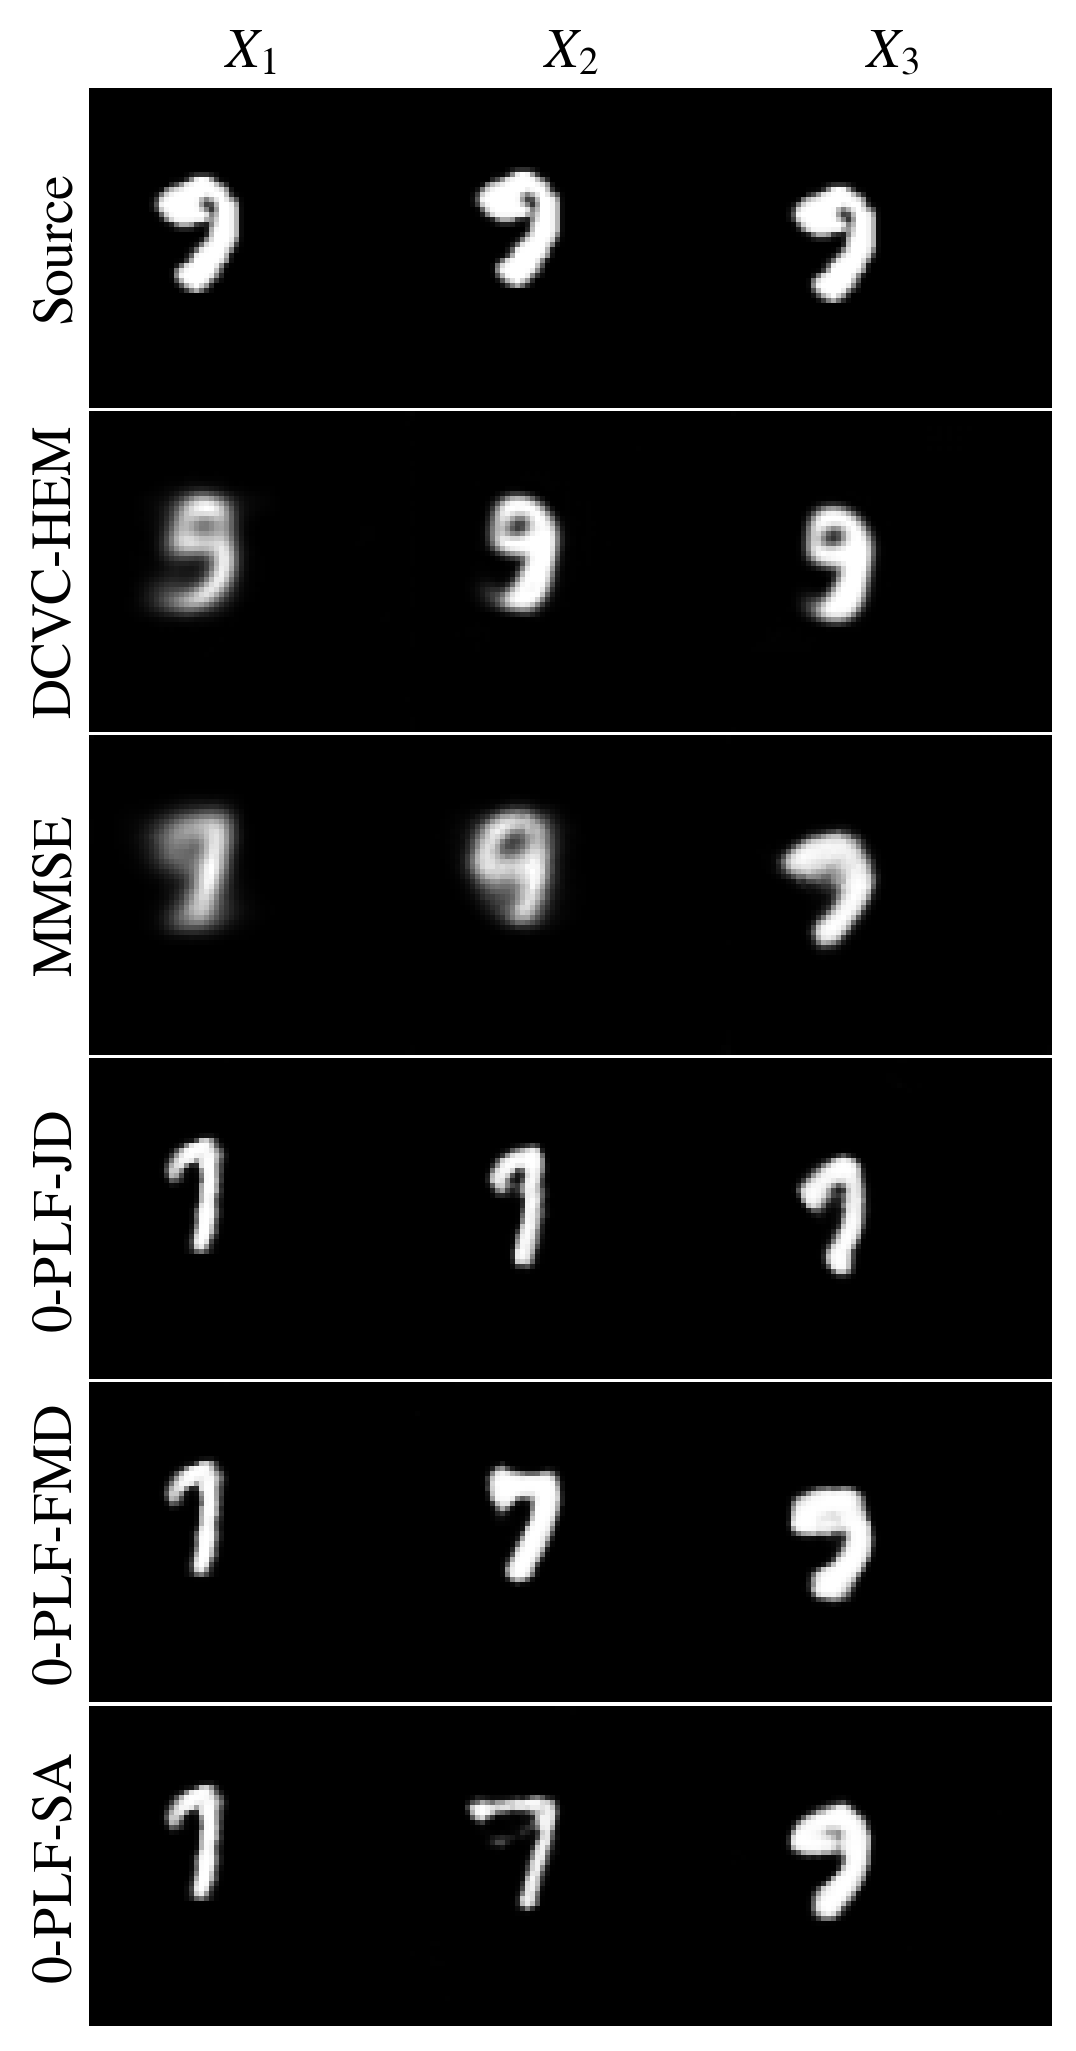

In [8]:
loader, _ = get_dataloader(data_root='./data/', seq_len=3, batch_size=64, num_digits=1)
x = next(iter(loader)).permute(0, 4, 1, 2, 3).to(device).float()

x1_hat, x_ref = R1_eps_eps(x, l_FMD=0.04 ,l_AR=0.08, l_JD=0.08, eps=12, letter='c')

In [98]:
def mmnist_psnr_lpips(test_loader, l_FMD = 0.0 ,l_AR = 0, l_JD = 0, eps = 12, letter = 'a'):
    z_dim = eps // 2
    # path to load trained models from
    pre_path_AR_1  = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|' + \
                        f'lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{l_AR}|lambdaMSE_1.0_old'
    pre_path_JD_1  = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|' + \
                        f'lambdaJD_{l_JD}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0_old'
    pre_path_FMD_1 = f'./saved_models/R1-eps/{eps}/R1-eps|dim_128|z_dim_{z_dim}|L_2|' + \
                        f'lambdaJD_0.0|lambdaFMD_{l_FMD}|lambdaNEW_0.0|lambdaMSE_1.0_old'
    
    pre_path_AR_2  = f'./saved_models/R1-eps-eps/{eps}/12-{eps}-{eps}|lambdaJD_0.0|' + \
                        f'lambdaFMD_0.0|lambdaAR_{l_AR}|lambdaMSE_1.0|'
    pre_path_JD_2  = f'./saved_models/R1-eps-eps/{eps}/12-{eps}-{eps}|lambdaJD_{l_JD}|' + \
                        f'lambdaFMD_0.0|lambdaAR_0.0|lambdaMSE_1.0|'
    pre_path_FMD_2 = f'./saved_models/R1-eps-eps/{eps}/12-{eps}-{eps}|lambdaJD_0.0|' + \
                        f'lambdaFMD_{l_FMD}|lambdaAR_0.0|lambdaMSE_1.0|'

    # load fixed encoder for first frame
    encoder = Encoder(dim=12, nc=1, stochastic=True, quantize_latents=True, L=2).to(device).eval() 
    decoder = Decoder_Iframe(dim=12).to(device).eval()
    decoder_hat = Decoder_Iframe(dim=12).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #load ssf models for second frame
    ssf_AR_1 = ScaleSpaceFlow_R1eps(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_AR_1 = load_ssf_model(ssf_AR_1, pre_path_AR_1)

    ssf_JD_1 = ScaleSpaceFlow_R1eps(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_JD_1 = load_ssf_model(ssf_JD_1, pre_path_JD_1)
    
    ssf_FMD_1 = ScaleSpaceFlow_R1eps(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, L=2).to(device).eval()
    ssf_FMD_1 = load_ssf_model(ssf_FMD_1, pre_path_FMD_1)
    
    # load ssf models for third frame
    ssf_AR_2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, 
        L=2, single_bit=False,num_c=1, activation=torch.sigmoid).to(device).eval()
    ssf_AR_2 = load_ssf_model(ssf_AR_2, pre_path_AR_2)
    
    ssf_JD_2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, 
        L=2, single_bit=False,num_c=1, activation=torch.sigmoid).to(device).eval()
    ssf_JD_2 = load_ssf_model(ssf_JD_2, pre_path_JD_2)
    
    ssf_FMD_2 = ScaleSpaceFlow_R1eps_e2e_3frames(
        num_levels=1, dim=z_dim, stochastic=True, quantize_latents=True, 
        L=2, single_bit=False,num_c=1, activation=torch.sigmoid).to(device).eval()
    ssf_FMD_2 = load_ssf_model(ssf_FMD_2, pre_path_FMD_2)

    # original frames
    length = 100
    test_loader = itertools.islice(test_loader, length)
    x1_psnr = {'JD': [], 'FMD': [], 'AR': [], 'DCVC': [], 'H.264': []}
    x2_psnr = {'JD': [], 'FMD': [], 'AR': [], 'DCVC': [], 'H.264': []}
    x1_lpips = {'JD': [], 'FMD': [], 'AR': [], 'DCVC': [], 'H.264': []}
    x2_lpips = {'JD': [], 'FMD': [], 'AR': [], 'DCVC': [], 'H.264': []}
    for x in tqdm(test_loader):
        x = x.permute(0, 4, 1, 2, 3).to(device).float()
        x0 = x[:, :, 0, :, :]
        x1 = x[:, :, 1, :, :]
        x2 = x[:, :, 2, :, :]

        # first frame
        hx0 = encoder(x[:, :, 0, ...])[0]
        x0_ref = decoder(hx0)
        x0_hat = decoder_hat(hx0).detach()

        # second frame
        x1_hat_JD  = ssf_JD_1(x[:, :, 1, ...], x0_ref, x0_hat)
        x1_hat_AR  = ssf_AR_1(x[:, :, 1, ...], x0_ref, x0_hat)
        x1_hat_FMD = ssf_FMD_1(x[:, :, 1, ...], x0_ref, x0_hat)

        # third frame
        x2_hat_JD  = ssf_JD_2(x[:, :, 2, ...], x1_hat_JD, x[:, :, 1, ...], x1_hat_JD)
        x2_hat_AR  = ssf_AR_2(x[:, :, 2, ...], x1_hat_AR, x[:, :, 1, ...], x1_hat_AR)
        x2_hat_FMD = ssf_FMD_2(x[:, :, 2, ...], x1_hat_FMD, x[:, :, 1, ...], x1_hat_FMD)

        # H.264 Compression
        x_hat_h264, h264_bits = run_h264(x.squeeze(), crf=100)
        x0_hat_h264 = x_hat_h264[0, :, :].unsqueeze(0).unsqueeze(0)
        x1_hat_h264 = x_hat_h264[1, :, :].unsqueeze(0).unsqueeze(0)
        x2_hat_h264 = x_hat_h264[2, :, :].unsqueeze(0).unsqueeze(0)

        # DCVC-HEM
        x1_hat_dcvc, x2_hat_dcvc, dcvc_bits = run_dcvc_test(x0_hat, x)
        
        x1_psnr_JD = PSNR(x1_hat_JD, x1)
        x2_psnr_JD = PSNR(x2_hat_JD, x2)
        x1_lpips_JD = LPIPS(x1_hat_JD, x1).item()
        x2_lpips_JD = LPIPS(x2_hat_JD, x2).item()
        # print(f"PLF-JD:  PSNR {x1_psnr_JD:.2f} {x2_psnr_JD:.2f} | " +
        #       f"LPIPS {x1_lpips_JD:.2f} {x2_lpips_JD:.2f}")
        x1_psnr['JD'].append(x1_psnr_JD)
        x2_psnr['JD'].append(x2_psnr_JD)
        x1_lpips['JD'].append(x1_lpips_JD)
        x2_lpips['JD'].append(x2_lpips_JD)

        x1_psnr_FMD = PSNR(x1_hat_FMD, x1)
        x2_psnr_FMD = PSNR(x2_hat_FMD, x2)
        x1_lpips_FMD = LPIPS(x1_hat_FMD, x1).item()
        x2_lpips_FMD = LPIPS(x2_hat_FMD, x2).item()
        # print(f"PLF-FMD: PSNR {x1_psnr_FMD:.2f} {x2_psnr_FMD:.2f} | " + 
        #       f"LPIPS {x1_lpips_FMD:.2f} {x2_lpips_FMD:.2f}")
        x1_psnr['FMD'].append(x1_psnr_FMD)
        x2_psnr['FMD'].append(x2_psnr_FMD)
        x1_lpips['FMD'].append(x1_lpips_FMD)
        x2_lpips['FMD'].append(x2_lpips_FMD)

        x1_psnr_AR = PSNR(x1_hat_AR, x1)
        x2_psnr_AR = PSNR(x2_hat_AR, x2)
        x1_lpips_AR = LPIPS(x1_hat_AR, x1).item()
        x2_lpips_AR = LPIPS(x2_hat_AR, x2).item()
        # print(f"PLF-AR:  PSNR {x1_psnr_AR:.2f} {x2_psnr_AR:.2f} | " +
        #       f"LPIPS {x1_lpips_AR:.2f} {x2_lpips_AR:.2f}")
        x1_psnr['AR'].append(x1_psnr_AR)
        x2_psnr['AR'].append(x2_psnr_AR)
        x1_lpips['AR'].append(x1_lpips_AR)
        x2_lpips['AR'].append(x2_lpips_AR)

        x1_psnr_DCVC = PSNR(x1_hat_dcvc, x1)
        x2_psnr_DCVC = PSNR(x2_hat_dcvc, x2)
        x1_lpips_DCVC = LPIPS(x1_hat_dcvc, x1).item()
        x2_lpips_DCVC = LPIPS(x2_hat_dcvc, x2).item()
        # print(f"DCVC:    PSNR {x1_psnr_DCVC:.2f} {x2_psnr_DCVC:.2f} | " + 
        #       f"LPIPS {x1_lpips_DCVC:.2f} {x2_lpips_DCVC:.2f}")
        x1_psnr['DCVC'].append(x1_psnr_DCVC)
        x2_psnr['DCVC'].append(x2_psnr_DCVC)
        x1_lpips['DCVC'].append(x1_lpips_DCVC)
        x2_lpips['DCVC'].append(x2_lpips_DCVC)

        x1_psnr_h264 = PSNR(x1_hat_h264, x1)
        x2_psnr_h264 = PSNR(x2_hat_h264, x2)
        x1_lpips_h264 = LPIPS(x1_hat_h264, x1).item()
        x2_lpips_h264 = LPIPS(x2_hat_h264, x2).item()
        # print(f"H264:    PSNR {x1_psnr_h264:.2f} {x2_psnr_h264:.2f} | " + 
        #       f"LPIPS {x1_lpips_h264:.2f} {x2_lpips_h264:.2f}")
        x1_psnr['H.264'].append(x1_psnr_h264)
        x2_psnr['H.264'].append(x2_psnr_h264)
        x1_lpips['H.264'].append(x1_lpips_h264)
        x2_lpips['H.264'].append(x2_lpips_h264)

    x1_JD_avg_psnr = sum(x1_psnr['JD']) / length
    x2_JD_avg_psnr = sum(x2_psnr['JD']) / length
    x1_JD_avg_lpips = sum(x1_lpips['JD']) / length
    x2_JD_avg_lpips = sum(x2_lpips['JD']) / length
    
    x1_FMD_avg_psnr = sum(x1_psnr['FMD']) / length
    x2_FMD_avg_psnr = sum(x2_psnr['FMD']) / length
    x1_FMD_avg_lpips = sum(x1_lpips['FMD']) / length
    x2_FMD_avg_lpips = sum(x2_lpips['FMD']) / length
    
    x1_AR_avg_psnr = sum(x1_psnr['AR']) / length
    x2_AR_avg_psnr = sum(x2_psnr['AR']) / length
    x1_AR_avg_lpips = sum(x1_lpips['AR']) / length
    x2_AR_avg_lpips = sum(x2_lpips['AR']) / length
    
    x1_DCVC_avg_psnr = sum(x1_psnr['DCVC']) / length
    x2_DCVC_avg_psnr = sum(x2_psnr['DCVC']) / length
    x1_DCVC_avg_lpips = sum(x1_lpips['DCVC']) / length
    x2_DCVC_avg_lpips = sum(x2_lpips['DCVC']) / length
    
    x1_h264_avg_psnr = sum(x1_psnr['H.264']) / length
    x2_h264_avg_psnr = sum(x2_psnr['H.264']) / length
    x1_h264_avg_lpips = sum(x1_lpips['H.264']) / length
    x2_h264_avg_lpips = sum(x2_lpips['H.264']) / length
    
    print(f'Second frame PSNR:  JD {x1_JD_avg_psnr:.4f} | FMD {x1_FMD_avg_psnr:.4f} | ' + \
          f'AR {x1_AR_avg_psnr:.4f} | DCVC {x1_DCVC_avg_psnr:.4f} | H.264 {x1_h264_avg_psnr:.4f}')
    print(f'Second frame LPIPS: JD {x1_JD_avg_lpips:.4f} | FMD {x1_FMD_avg_lpips:.4f} | ' + \
          f'AR {x1_AR_avg_lpips:.4f} | DCVC {x1_DCVC_avg_lpips:.4f} | H.264 {x1_h264_avg_lpips:.4f}')
    
    print(f'Third frame PSNR:  JD {x2_JD_avg_psnr:.4f} | FMD {x2_FMD_avg_psnr:.4f} | ' + \
          f'AR {x2_AR_avg_psnr:.4f} | DCVC {x2_DCVC_avg_psnr:.4f} | H.264 {x2_h264_avg_psnr:.4f}')
    print(f'Third frame LPIPS: JD {x2_JD_avg_lpips:.4f} | FMD {x2_FMD_avg_lpips:.4f} | ' + \
          f'AR {x2_AR_avg_lpips:.4f} | DCVC {x2_DCVC_avg_lpips:.4f} | H.264 {x2_h264_avg_lpips:.4f}')

In [8]:
_, loader = get_dataloader(data_root='./data/', seq_len=3, batch_size=1, num_digits=1)

mmnist_psnr_lpips(loader, l_FMD=0.04 ,l_AR=0.08, l_JD=0.08, eps=12, letter = 'c')

Finished Loading MNIST!
[-1.0, 1.0]


/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


0it [00:00, ?it/s]/h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811805959/work/torch/csrc/utils/tensor_numpy.cpp:189.)
100it [02:11,  1.32s/it]

Second frame PSNR:  JD 16.6316 | FMD 17.8421 | AR 17.8122 | DCVC 19.6924 | H.264 20.1976
Second frame LPIPS: JD 0.1200 | FMD 0.0945 | AR 0.1066 | DCVC 0.2234 | H.264 0.2383
Third frame PSNR:  JD 17.7214 | FMD 23.0887 | AR 23.0711 | DCVC 17.8282 | H.264 21.0181
Third frame LPIPS: JD 0.1130 | FMD 0.0432 | AR 0.0421 | DCVC 0.3502 | H.264 0.2357
